In [1]:
import warnings
warnings.filterwarnings('ignore')

In [36]:
import pandas as pd
from heamy.dataset import Dataset
from heamy.estimator import Classifier
import lightgbm as lgb
import xgboost as xgb
import catboost as cb
from sklearn.model_selection import train_test_split
from heamy.pipeline import ModelsPipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.metrics import roc_curve, auc 
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import metrics
import eli5 
from eli5.sklearn import PermutationImportance
import shap 
from pdpbox import pdp, info_plots
from sklearn.model_selection import GridSearchCV
np.random.seed(2022) 
pd.options.mode.chained_assignment = None  
%matplotlib inline
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [4]:
pd.set_option('display.max_rows', None)    #显示所有行

In [5]:
df = pd.read_excel(r"E:\ADMA\data\读研数据.xlsx")
df.head()

,employment_pressure,Influence_of_relatives_and_friends,Improve_ability,Postgraduate_trend,Employment_prospects,Famous_school_complex,Professional_interests,Personal_development,target
0,5,3,3,5,5,4,3,5,是
1,4,5,3,4,5,4,5,3,是
2,4,3,3,4,4,3,3,3,是
3,4,5,5,3,4,5,5,4,是
4,3,4,1,2,4,5,5,4,是


In [6]:
df['target'].replace(['否', '是'], [0, 1],inplace= True)
# 切分数据
X_train, X_test, y_train, y_test = train_test_split(df.drop('target', 1), df['target'], test_size = .3, random_state=10)

In [8]:
# grid search 选择模型的超参数
param_grid = {
        "n_estimators": [40,50, 70, 90], # 多少棵树
        "learning_rate": [0.01, 0.03, 0.05, 0.1, 0.2], # 学习率
        "max_depth": [2,3,4,5], # 树的最大深度
        "colsample_bytree": [0.4,0.6,0.8,1], # 选择多少列构建一个树
        "min_child_weight": [1,2,3,4] # 叶子节点最小样本数目
    }
# 构建grid search 模型， 5折交叉验证。
search = GridSearchCV(xgb.XGBClassifier(objective="binary:logistic", random_state=1898), param_grid, n_jobs=2, scoring="roc_auc", cv=5)
search

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_ca...
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                        

In [9]:
search.fit(X_train, y_train)
#返回最优的训练器
best_estimator = search.best_estimator_
print(best_estimator)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.4,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=2, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=50, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=1898,
              reg_alpha=0, reg_lambda=1, ...)


In [10]:
search.best_params_

{'colsample_bytree': 0.4,
 'learning_rate': 0.1,
 'max_depth': 2,
 'min_child_weight': 1,
 'n_estimators': 50}

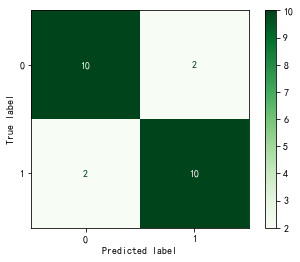

In [11]:
# 2.3.1 混淆矩阵
# 模型预测
y_predict = best_estimator.predict(X_test)
y_pred_quant = best_estimator.predict_proba(X_test)[:,1]
y_pred_bin = best_estimator.predict(X_test)

# 混淆矩阵
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,y_pred_bin)
cm
# 可视化混淆矩阵
from sklearn.metrics import ConfusionMatrixDisplay
cm_display = ConfusionMatrixDisplay(cm).plot(cmap = 'Greens')

In [12]:
# 2.3.2 模型常规评价
# 模型评价表
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83        12
           1       0.83      0.83      0.83        12

    accuracy                           0.83        24
   macro avg       0.83      0.83      0.83        24
weighted avg       0.83      0.83      0.83        24



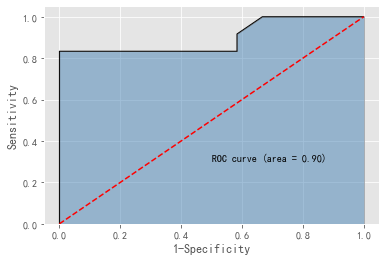

In [15]:
# 设置绘图风格（不妨使用R语言中的ggplot2风格）
plt.style.use('ggplot')
# 计算概率值，用于生成ROC曲线的数据
y_score = best_estimator.predict_proba(X_test)[:,1]
fpr,tpr,threshold = metrics.roc_curve(y_test, y_score, pos_label=1)
# 计算AUC的值
roc_auc = metrics.auc(fpr,tpr)

# 绘制面积图
plt.stackplot(fpr, tpr, color='steelblue', alpha = 0.5, edgecolor = 'black')
# 添加边际线
plt.plot(fpr, tpr, color='black', lw = 1)
# 添加对角线
plt.plot([0,1],[0,1], color = 'red', linestyle = '--')
# 添加文本信息
plt.text(0.5,0.3,'ROC curve (area = %0.2f)' % roc_auc)
# 添加x轴与y轴标签
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
# 显示图形
plt.show()

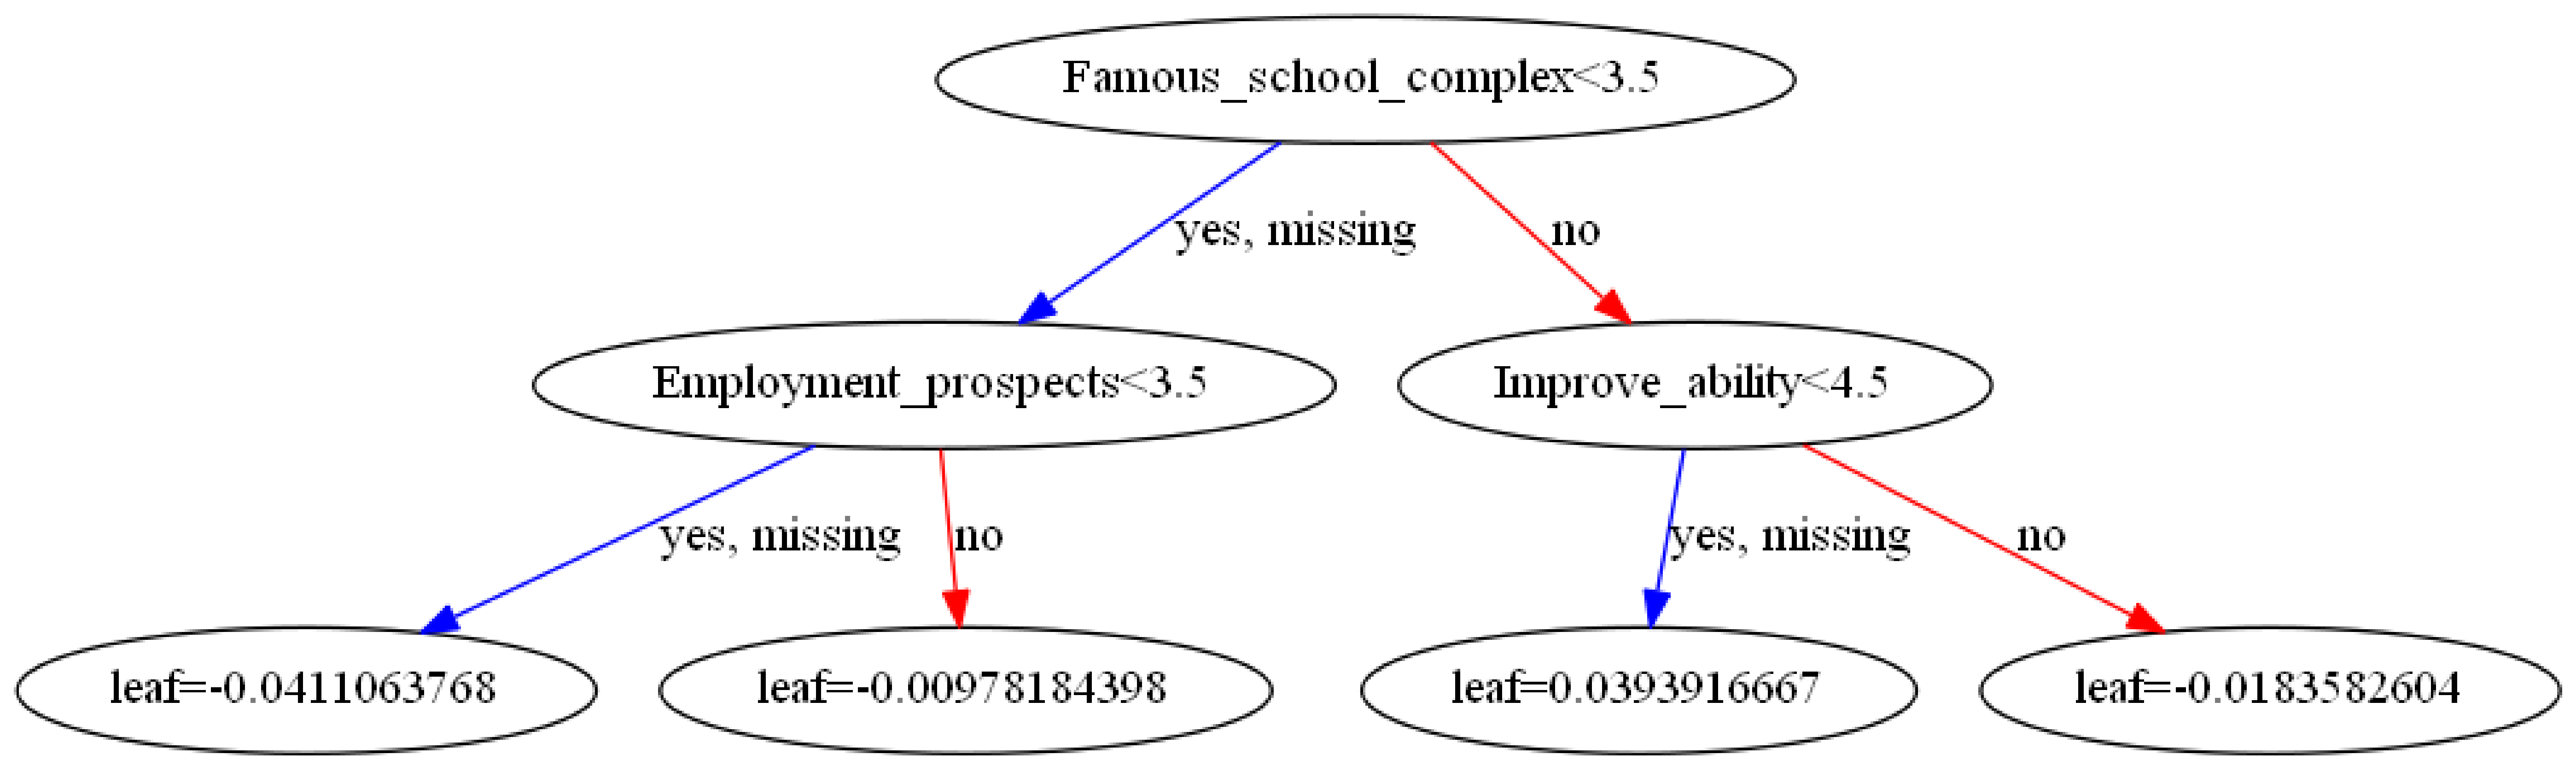

In [17]:
def create_feature_map(features):
    outfile = open('clf.fmap','w')
    for i,f in enumerate(features):
        outfile.write('{0}\t{1}\tq\n'.format(i,f))
    outfile.close()
create_feature_map(X_train.columns)    # 特别需要注意：列名字中不能有空格。
xgb.plot_tree(best_estimator, num_trees=49, fmap='clf.fmap')
fig = plt.gcf()
fig.set_size_inches(100,100)

In [18]:
# 2.4.1 每个变量对模型的重要性
perm = PermutationImportance(best_estimator, random_state=10).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_train.columns.tolist())

Weight,Feature
0.1083 ± 0.1453,Famous_school_complex
0.0667 ± 0.0667,Influence_of_relatives_and_friends
0.0250 ± 0.0850,Employment_prospects
0.0083 ± 0.0333,Personal_development
0.0083 ± 0.0333,Professional_interests
0 ± 0.0000,Postgraduate_trend
0 ± 0.0000,employment_pressure
-0.0250 ± 0.0408,Improve_ability


In [19]:
eli5.show_prediction(best_estimator, X_test.iloc[0], feature_names = X_train.columns.tolist(), show_feature_values=True)

In [20]:
eli5.show_prediction(best_estimator, X_test.iloc[1], feature_names = X_train.columns.tolist(), show_feature_values=True)

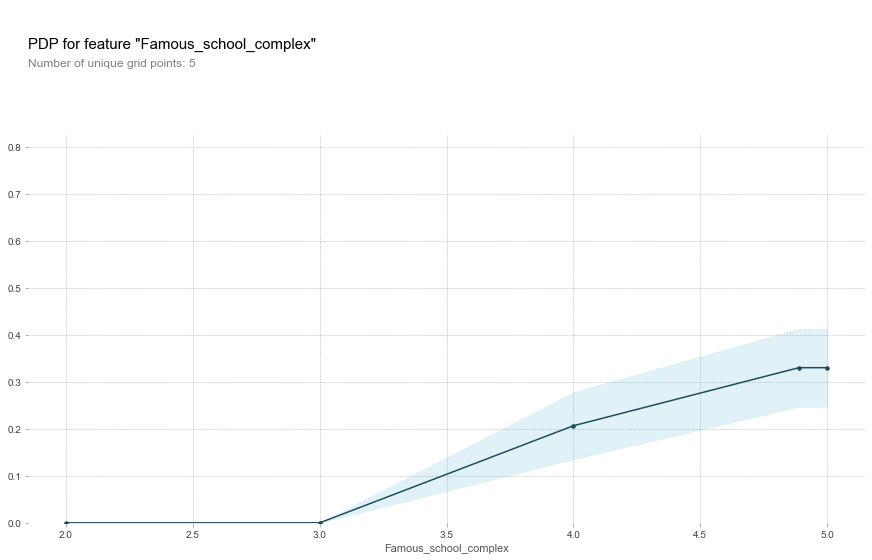

In [22]:
# 2.4.2 部分依赖图
# 一维 PDP
base_features = df.columns.values.tolist()
base_features.remove('target')

feat_name = 'Famous_school_complex'
pdp_dist = pdp.pdp_isolate(
    model=best_estimator,  # 模型
    dataset=X_test,  # 测试集
    model_features=base_features,  # 特征变量；除去目标值 
    feature=feat_name  # 指定单个字段
) 
pdp.pdp_plot(pdp_dist, feat_name)  # 传入两个参数
plt.show()

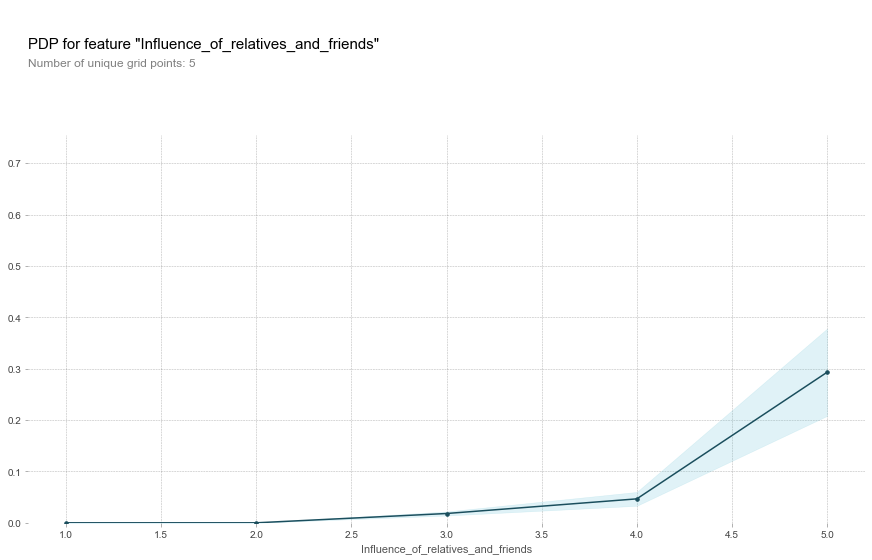

In [23]:
# 2.4.2 部分依赖图
# 一维 PDP
base_features = df.columns.values.tolist()
base_features.remove('target')

feat_name = 'Influence_of_relatives_and_friends'
pdp_dist = pdp.pdp_isolate(
    model=best_estimator,  # 模型
    dataset=X_test,  # 测试集
    model_features=base_features,  # 特征变量；除去目标值 
    feature=feat_name  # 指定单个字段
) 
pdp.pdp_plot(pdp_dist, feat_name)  # 传入两个参数
plt.show()

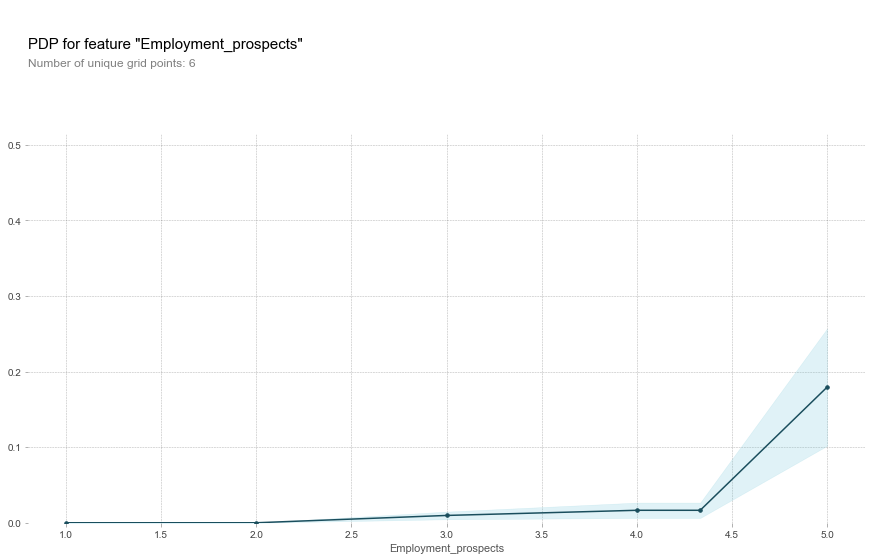

In [24]:
# 2.4.2 部分依赖图
# 一维 PDP
# 以血管数量为特征来看
base_features = df.columns.values.tolist()
base_features.remove('target')

feat_name = 'Employment_prospects' 
pdp_dist = pdp.pdp_isolate(
    model=best_estimator,  # 模型
    dataset=X_test,  # 测试集
    model_features=base_features,  # 特征变量；除去目标值 
    feature=feat_name  # 指定单个字段
) 
pdp.pdp_plot(pdp_dist, feat_name)  # 传入两个参数
plt.show()

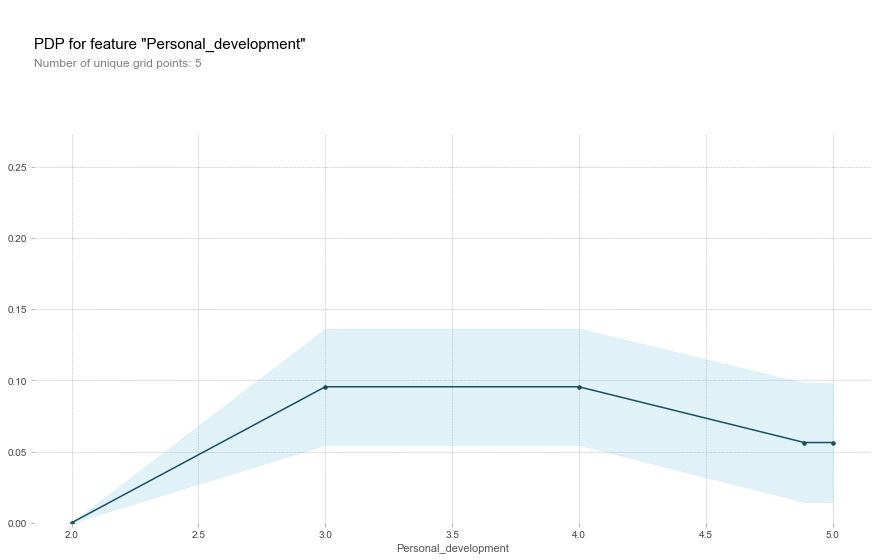

In [26]:
# 2.4.2 部分依赖图
# 一维 PDP
base_features = df.columns.values.tolist()
base_features.remove('target')

feat_name = 'Personal_development' 
pdp_dist = pdp.pdp_isolate(
    model=best_estimator,  # 模型
    dataset=X_test,  # 测试集
    model_features=base_features,  # 特征变量；除去目标值 
    feature=feat_name  # 指定单个字段
) 
pdp.pdp_plot(pdp_dist, feat_name)  # 传入两个参数
plt.show()

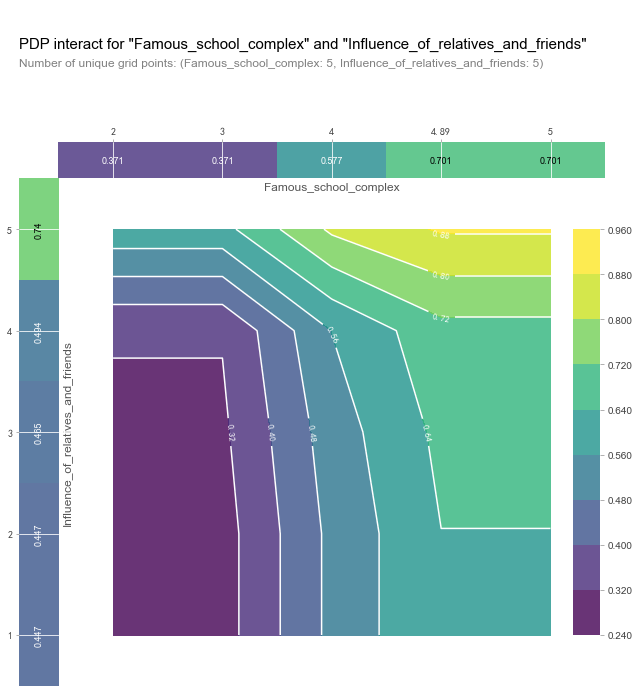

In [27]:
inter1  =  pdp.pdp_interact(
    model=best_estimator,  # 模型
    dataset=X_test,  # 特征数据集
    model_features=base_features,  # 特征
    features=['Famous_school_complex', 'Influence_of_relatives_and_friends'])

pdp.pdp_interact_plot(
    pdp_interact_out=inter1, 
    feature_names=['Famous_school_complex', 'Influence_of_relatives_and_friends'], 
    plot_type='contour',
 plot_pdp=True)
plt.show()

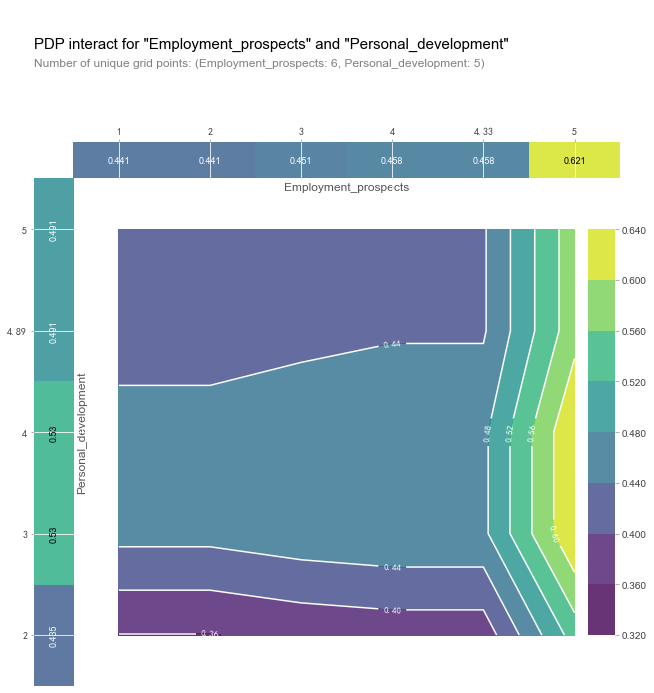

In [28]:
inter1  =  pdp.pdp_interact(
    model=best_estimator,  # 模型
    dataset=X_test,  # 特征数据集
    model_features=base_features,  # 特征
    features=['Employment_prospects', 'Personal_development'])

pdp.pdp_interact_plot(
    pdp_interact_out=inter1, 
    feature_names=['Employment_prospects', 'Personal_development'], 
    plot_type='contour',
 plot_pdp=True)
plt.savefig('PDP图.png', dpi = 1200)
plt.show()

In [38]:
# 2.4.3 SHAP
explainer = shap.TreeExplainer(best_estimator)  
# 在explainer中传入特征值的数据，计算shap值
shap_values = explainer.shap_values(X_test)

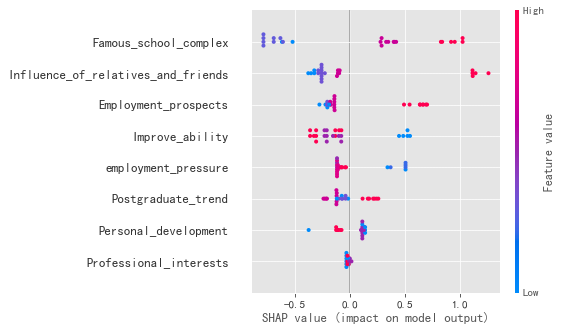

In [30]:
# 2.4.3 SHAP
# summary_plot
# summarize the effects of all the features
shap.summary_plot(shap_values,X_test)

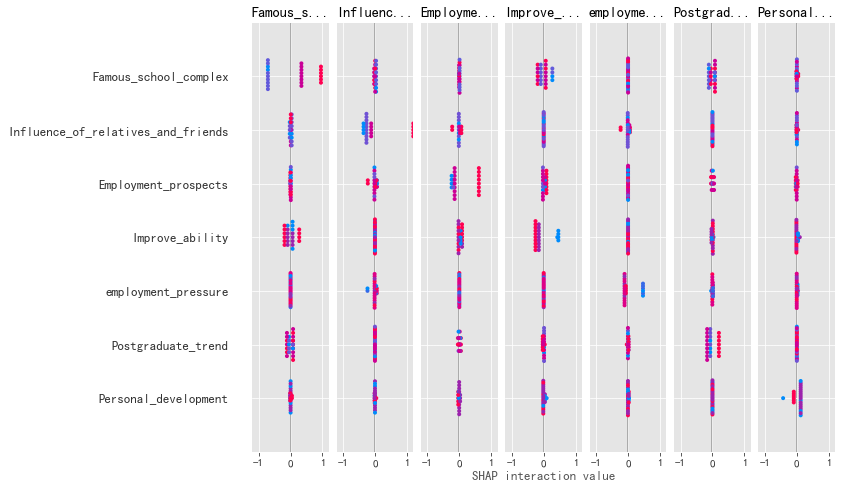

In [31]:
shap_interaction_values = explainer.shap_interaction_values(X_test)
shap.summary_plot(shap_interaction_values, X_test)